In [1]:
import math

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from time import sleep

- [Data Preparation](#data)
- [Question 1. How has the size of NBA players changed over time?](#q1)
- [Question 2. Do top scorers show any different trends?](#q2)
- [Question 3. Why Are NBA Players Getting Smaller?](#q3)
- [Question 4. Why are players talking more 3 point shots now?](#q4)
- [Question 5. Why didn't they shoot more 3 pointers before?](#q5)
- [Takeaways](#takeaways)

<a id="data"></a>

## Data Preparation

#### Import NBA Roster Historical Data

In [2]:
roster = pd.read_csv('data_files/nba_league_roster_historical.csv')
roster = roster[["Player","Height","Weight"]]
roster = roster.dropna()
roster = roster.set_index("Player")

In [3]:
roster["total_inches"] = roster["Height"].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))
roster.head()

,Height,Weight,total_inches
Player,,,
AlaaAbdelnaby,6-10,240.0,82
ZaidAbdul-Aziz,6-9,235.0,81
KareemAbdul-Jabbar,7-2,225.0,86
MahmoudAbdul-Rauf,6-1,162.0,73
TariqAbdul-Wahad,6-6,235.0,78


#### Import Player Totals

In [4]:
totals = pd.read_csv('data_files/Player Totals.csv')
totals = totals[totals["season"] >= 1980]
totals = totals.set_index("seas_id")

# Remove space in player column
totals['player'] = totals['player'].str.replace(' ','')
# Add decade column
totals["decade"] = totals["season"].map(lambda x: f'{x-x%10}s')
# Add 5-year-stretch column
totals["5-yr"] = totals["season"].map(lambda x: f'{x-x%5}-{x-x%5+4}')

#### Import Player Per Game

In [5]:
per_game = pd.read_csv('data_files/Player Per Game.csv')
per_game = per_game[per_game["season"] >= 1980]
per_game = per_game.set_index("seas_id")

# Remove space in player column
per_game['player'] = per_game['player'].str.replace(' ','')
# Add decade column
per_game["decade"] = per_game["season"].map(lambda x: f'{x-x%10}s')
# Add 5-year-stretch column
per_game["5-yr"] = per_game["season"].map(lambda x: f'{x-x%5}-{x-x%5+4}')

#### Join Datasets with Roster

In [6]:
rstr_ttl = pd.merge(roster, totals, left_on="Player", right_on="player")
rstr_pg = pd.merge(roster, per_game, left_on="Player", right_on="player")

#### Import Team Stats Per Game

In [7]:
tm_sts_pg = pd.read_csv('data_files/Team Stats Per Game.csv')
tm_sts_pg = tm_sts_pg[tm_sts_pg["season"] >= 1980]

# Add decade column
tm_sts_pg["decade"] = tm_sts_pg["season"].map(lambda x: f'{x-x%10}s')
# Add 5-year-stretch column
tm_sts_pg["5-year-stretch"] = tm_sts_pg["season"].map(lambda x: f'{x-x%5}-{x-x%5+4}')

In [8]:
tm_sts_pg_grouped = tm_sts_pg.groupby("5-year-stretch").mean(numeric_only=True)
tm_sts_pg_grouped["expected_pts_from_3pa"] = tm_sts_pg_grouped["x3p_percent"] * 3
tm_sts_pg_grouped["expected_pts_from_2pa"] = tm_sts_pg_grouped["x2p_percent"] * 2

<a id="q1"></a>

## Question 1. How has the size of NBA players changed over time?

One of the things that stands out for anyone about the professional basketball players in NBA, the best basketball in the world, is their size. Basketball players are tall, and therefore heavy.

Since I was able to get ahold of biographical data of NBA players including those who are already retired from the official NBA website, let's see the trend in their height and weight.

In [9]:
grouped_df = rstr_ttl.groupby("5-yr").mean(numeric_only=True)[["total_inches","Weight"]]

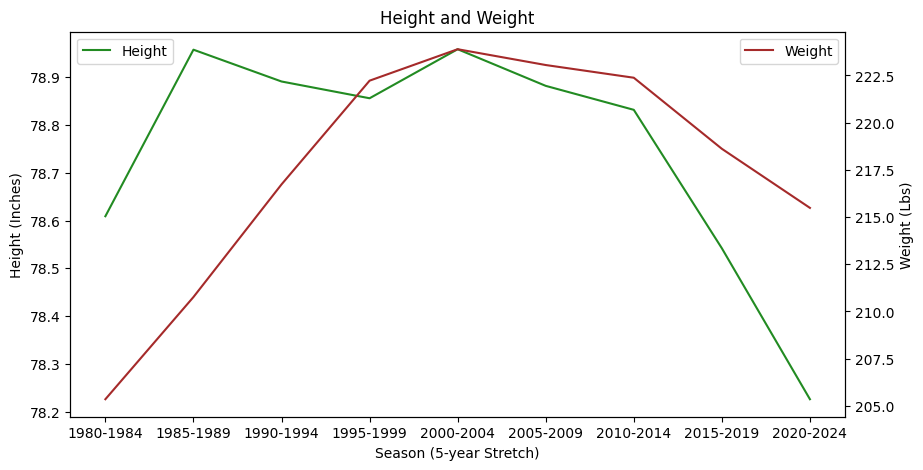

In [10]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlabel('Season (5-year Stretch)')
ax1.set_ylabel('Height (Inches)')
ax1.plot(grouped_df.index, grouped_df["total_inches"], color="forestgreen", label="Height")

ax2 = ax1.twinx()
ax2.set_ylabel('Weight (Lbs)')
ax2.plot(grouped_df.index, grouped_df["Weight"], color="brown", label="Weight")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Height and Weight")
plt.show()

In this graph, we can observe three distinct phases:

- 1980-1984 to 1990-1994: Tall but Light
    - Players were already at their height peak, with the average height mostly above 78.8 inches.
    - However, the average weight was smaller compared to what it would later become. This was possibly due to limited access to training methods and nutrition that modern-day professional athletes have.

- 1995-1999 to 2010-2014: Tall and Heavy
    - Players remained as tall as their predecessors, but their average weight reached its peak.

- 2015-2019 to 2020-2024: Shorter and Lighter
    - Players are now becoming shorter and lighter.
    - Despite the league consistently attracting more talented players each year, thanks to the sport's growing popularity, both the average height and weight are decreasing.
    - The average height is now lower than it was during the 1980-1984 era.

### Change in Height Distribution

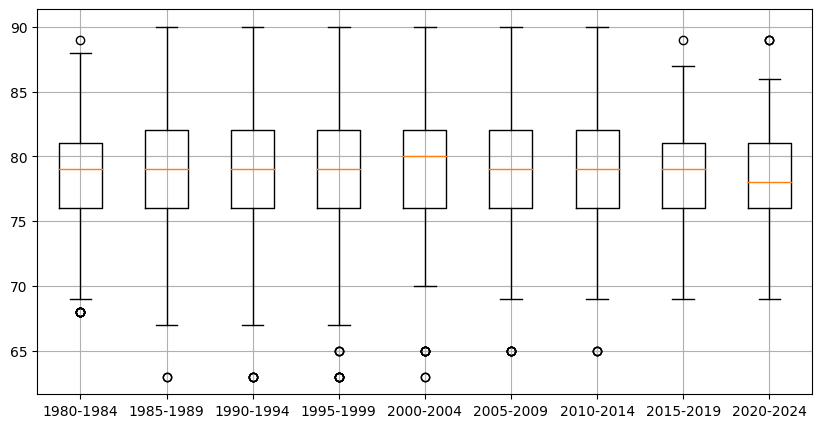

In [11]:
plt.figure(figsize=(10,5))
timeframes = rstr_ttl["5-yr"].unique()
timeframes.sort()

data=[]
labels=[]

for timeframe in timeframes:
    data.append(rstr_ttl[rstr_ttl["5-yr"] == timeframe]["total_inches"])
    labels.append(timeframe)
    
plt.boxplot(data,labels=labels)
plt.grid()
plt.show()

In this box chart, we can observe that the median height reached its peak during 2000-2004, but it has been gradually decreasing since then, along with a reduction in the overall distribution of height.

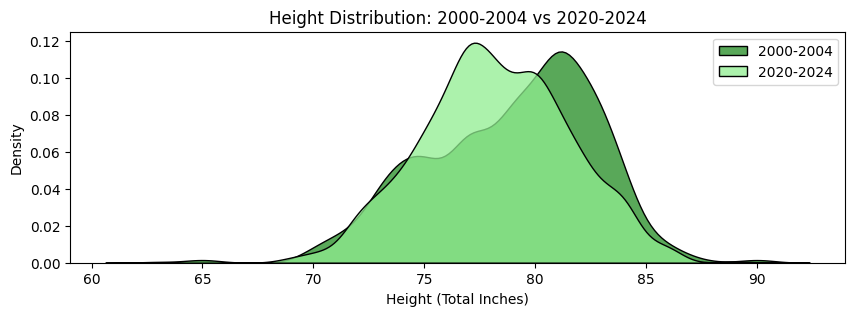

In [12]:
plt.figure(figsize=(10,3))
series1 = rstr_ttl[rstr_ttl["5-yr"] == "2000-2004"].total_inches
series2 = rstr_ttl[rstr_ttl["5-yr"] == "2020-2024"].total_inches

sns.kdeplot(data=series1,multiple="stack",label="2000-2004",color="forestgreen")
sns.kdeplot(data=series2,multiple="stack",label="2020-2024",color="lightgreen")
plt.legend()
plt.title("Height Distribution: 2000-2004 vs 2020-2024")
plt.xlabel("Height (Total Inches)")
plt.ylabel("Density")
plt.show()

When compared directly, the difference between 2000-2004 and 2020-2024 is very noticeable.

### Change in Weight Distribution

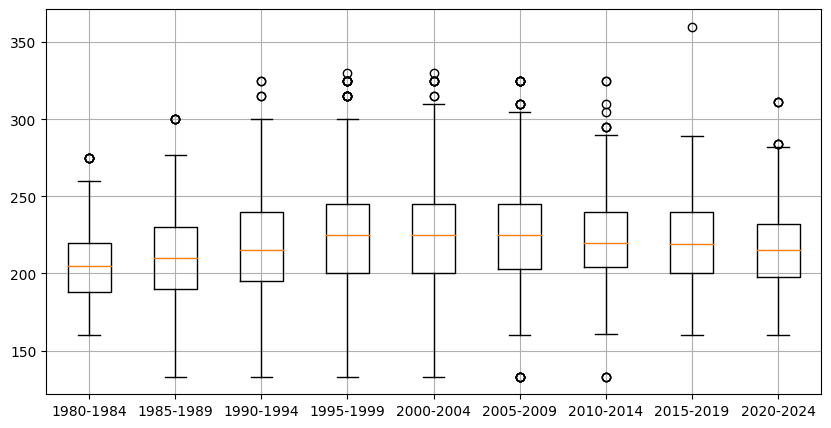

In [13]:
plt.figure(figsize=(10,5))
timeframes = rstr_ttl["5-yr"].unique()
timeframes.sort()

data=[]
labels=[]

for timeframe in timeframes:
    data.append(rstr_ttl[rstr_ttl["5-yr"] == timeframe]["Weight"])
    labels.append(timeframe)
    
plt.boxplot(data,labels=labels)
plt.grid()
plt.show()

The median weight of NBA players peaked around 1995-1999 and 2000-2004, with a wider distribution compared to the latest period.

When comparing the latest period to 1995-1999, it is apparent that the zone of typical player heights has shifted lower, indicating that NBA players are not as heavy as they once were.

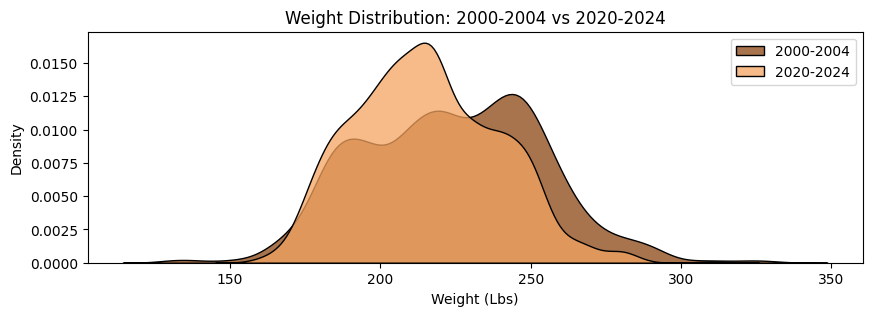

In [14]:
plt.figure(figsize=(10,3))
series1 = rstr_ttl[rstr_ttl["5-yr"] == "2000-2004"].Weight
series2 = rstr_ttl[rstr_ttl["5-yr"] == "2020-2024"].Weight

sns.kdeplot(data=series1,multiple="stack",label="2000-2004", color="saddlebrown")
sns.kdeplot(data=series2,multiple="stack",label="2020-2024", color="sandybrown")
plt.legend()
plt.title("Weight Distribution: 2000-2004 vs 2020-2024")
plt.xlabel("Weight (Lbs)")
plt.ylabel("Density")
plt.show()

### Answer to How has the size of NBA players changed over time?### Answer to ""

To answer the question "How has the size of NBA players changed over time?", it can be observed that players have always been tall, and there was a trend for them to be thicker up until the early 2000s. 

However, over the last decade, there has been a noticeable decrease in the size of players, as they have become both shorter and lighter.

---

<a id="q2"></a>

## Question 2. Do top scorers show any different trends?

The average size of NBA players has been decreasing, but it's worth investigating whether the top scorers in the league have a different body size than the rest of the players. 

To do this, we can compare the average height and weight of the top 10% scorers with the league average over the years.

In [15]:
top_scorers = rstr_pg[rstr_pg["pts_per_game"] >= rstr_pg["pts_per_game"].quantile(0.9)]

In [16]:
grouped_top_ten = top_scorers.groupby(["5-yr"])
grouped_top_ten = grouped_top_ten.mean(numeric_only=True)

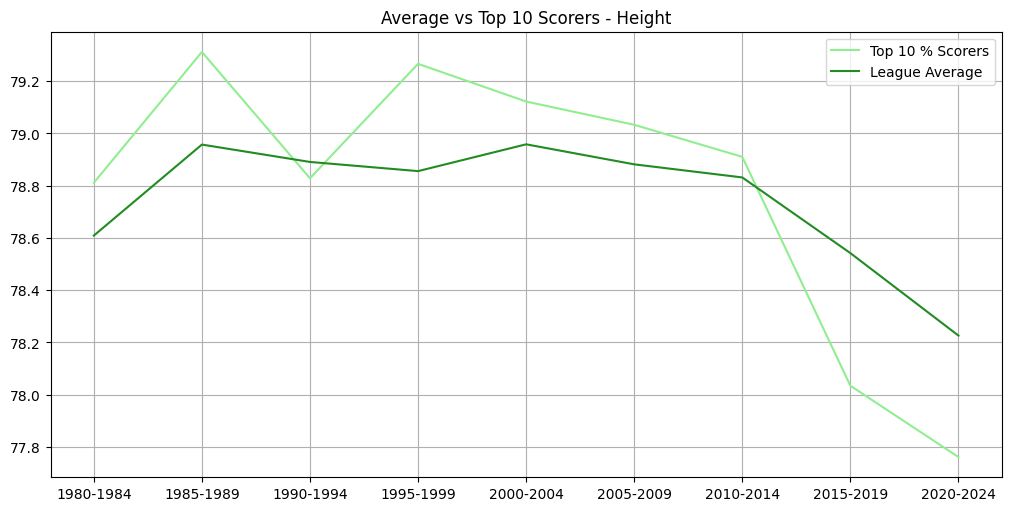

In [17]:
plt.figure(figsize=(10, 5), layout='constrained')
plt.title("Average vs Top 10 Scorers - Height")
plt.plot(grouped_top_ten.index, grouped_top_ten["total_inches"], color="lightgreen", label="Top 10 % Scorers")
plt.plot(grouped_df.index, grouped_df["total_inches"], color="forestgreen", label="League Average")
plt.legend()
plt.grid()
plt.show()

Top scorers in the NBA were typically taller than the league average in the past, but this trend has reversed since 2010-2014, with top scorers becoming shorter.

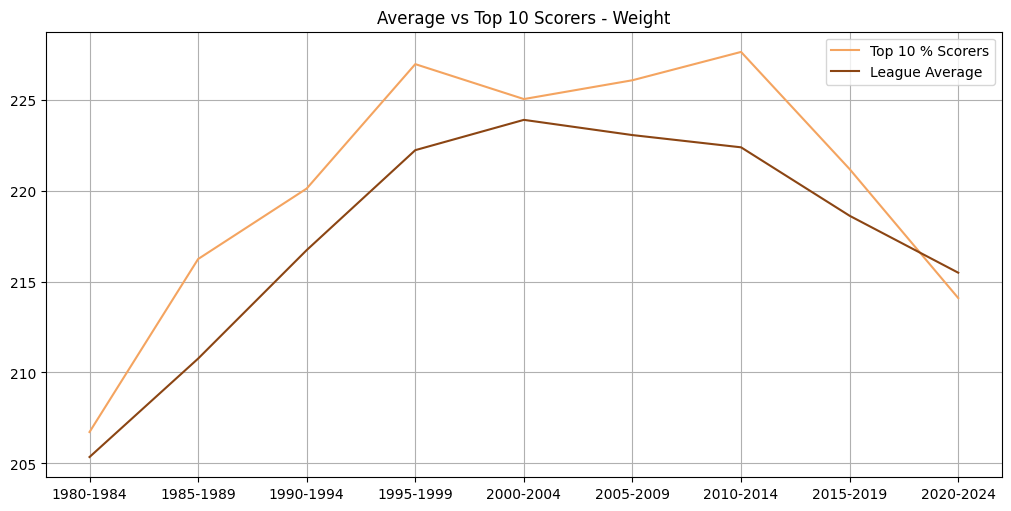

In [18]:
plt.figure(figsize=(10, 5), layout='constrained')
plt.title("Average vs Top 10 Scorers - Weight")
plt.plot(grouped_top_ten.index, grouped_top_ten["Weight"], color="sandybrown", label="Top 10 % Scorers")
plt.plot(grouped_df.index, grouped_df["Weight"], color="saddlebrown", label="League Average")
plt.legend()
plt.grid()
plt.show()

Like height, weight was also an advantage for top scorers in the past, but this has changed in recent years.

These findings are surprising because height and weight have long been considered advantageous for basketball players, especially for those who score the most points. 

### Answer to "Do top scorers show any different trends?"

In terms of trends, top scorers appear to be leading the way. They tend to be larger than the league average when player size is increasing, and smaller than the league average when player size is decreasing.

---

<a id="q3"></a>

## Question 3: Why Are NBA Players Getting Smaller?

Given that the trend of players becoming smaller is particularly noticeable among top scorers, let's take a closer look at what exactly "scoring" entails.

Scoring in basketball involves three methods: 2-pointers, 3-pointers, and free throws. Let's explore its impact on player scoring over the years.

### Scoring Involves more 3-pointers Nowadays

In [19]:
scoring_per_game = rstr_pg.assign(
    x2p_score_per_game=(rstr_pg["fg_per_game"]-rstr_pg["x3p_per_game"])*2,
    x3p_score_per_game=rstr_pg["x3p_per_game"]*3,
    ft_score_per_game=rstr_pg["ft_per_game"],
    expected_pts_from_2pa=rstr_pg["x2p_percent"] * 2,
    expected_pts_from_3pa=rstr_pg["x3p_percent"] * 3
)

In [20]:
grouped_scoring_per_game = scoring_per_game.groupby("5-yr").mean(numeric_only=True)

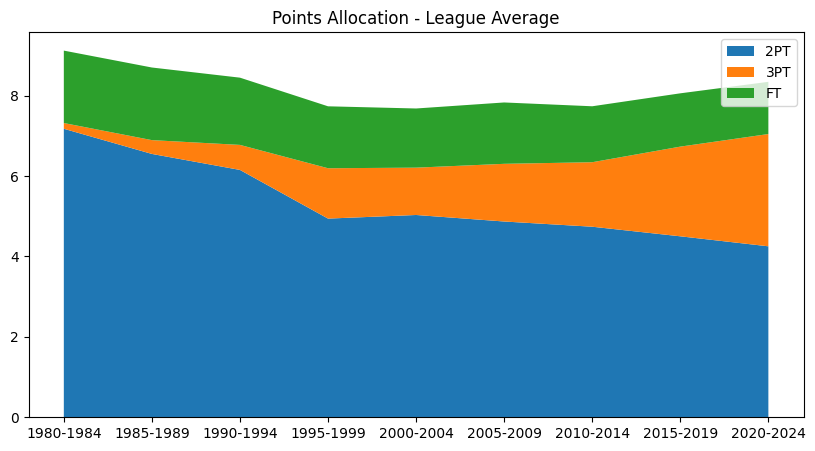

In [21]:
plt.figure(figsize=(10,5))
plt.stackplot(
    grouped_scoring_per_game.index,
    [
        grouped_scoring_per_game["x2p_score_per_game"],
        grouped_scoring_per_game["x3p_score_per_game"],
        grouped_scoring_per_game["ft_score_per_game"]
    ],
    labels=["2PT","3PT","FT"]
)
plt.legend()
plt.title("Points Allocation - League Average")
plt.show()

Over the years, number of points erned from 3 pointers is constantly increasing throught the league.

#### Top Scores follow the same distribution, but they shoot more

Now, do top scorers show any different trend?

In [22]:
grouped_scoring_per_game_top_ten = scoring_per_game[scoring_per_game["pts_per_game"] >= scoring_per_game["pts_per_game"].quantile(0.9)].groupby("5-yr").mean(numeric_only=True)

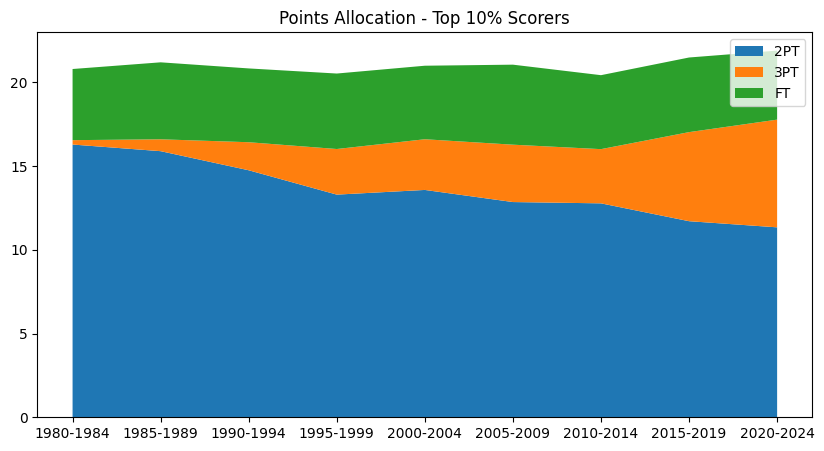

In [23]:
plt.figure(figsize=(10,5))
plt.stackplot(
    grouped_scoring_per_game_top_ten.index,
    [
        grouped_scoring_per_game_top_ten["x2p_score_per_game"],
        grouped_scoring_per_game_top_ten["x3p_score_per_game"],
        grouped_scoring_per_game_top_ten["ft_score_per_game"]
    ],
    labels=["2PT","3PT","FT"]
)
plt.legend()
plt.title("Points Allocation - Top 10% Scorers")
plt.show()

The proportion of each type of shot is nearly identical between the league average and top scorers, and the difference in scoring is primarily due to the higher volume of shots taken by the top scorers. Therefore, this trend is observed throughout the league.

Consistently making shots from beyond the 3-point line can significantly increase a player's score, regardless of their height. Shooting and making 3-pointers do not require as much height as attempting to score a 2-point shot closer to the basket.

### Answer to "Why Are NBA Players Getting Smaller?"

The increase in scoring from beyond the 3-point line indicates that there are more actions taking place away from the basket, involving a lot of running around with fewer obstacles around the player and the basket.

With the growing number of 3-point shots, smaller scorers now have a reliable way to score, meaning that being tall is no longer an absolute requirement for becoming a great scorer.

---

<a id="q4"></a>

## Question 4: Why are players talking more 3 point shots now?

Although smaller players are thriving in the current era of basketball that emphasizes more 3-point shots, the question remains: why are there more 3-point shots being taken nowadays?

### Actual Value of Shots

If every attempt at a 3-point shot yielded 3 points, and every attempt at a 2-point shot yielded 2 points, it would be logical to shoot every shot from behind the 3-point line. However, this is not the case, as points are only awarded for made shots.

Assuming a 50% success rate, the expected score for a 2-point shot would be 1.0 point per attempt. In contrast, the expected score for a 3-point shot, with the same 50% success rate, would be 1.5 points per attempt.

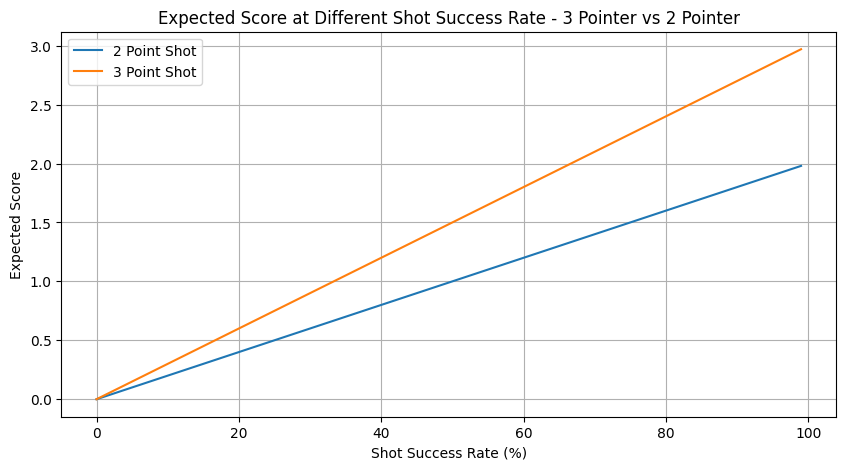

In [24]:
plt.figure(figsize=(10,5))

percentage = [i for i in range(100)]
three = [i*3/100 for i in range(100)]
two = [i*2/100 for i in range(100)]

plt.plot(percentage,two, label="2 Point Shot")
plt.plot(percentage,three, label="3 Point Shot")
plt.legend()
plt.xlabel("Shot Success Rate (%)")
plt.ylabel("Expected Score")
plt.title("Expected Score at Different Shot Success Rate - 3 Pointer vs 2 Pointer")
plt.grid()
plt.show()

Here is the field goal percentages of 2 pointers and 3 pointers over time.

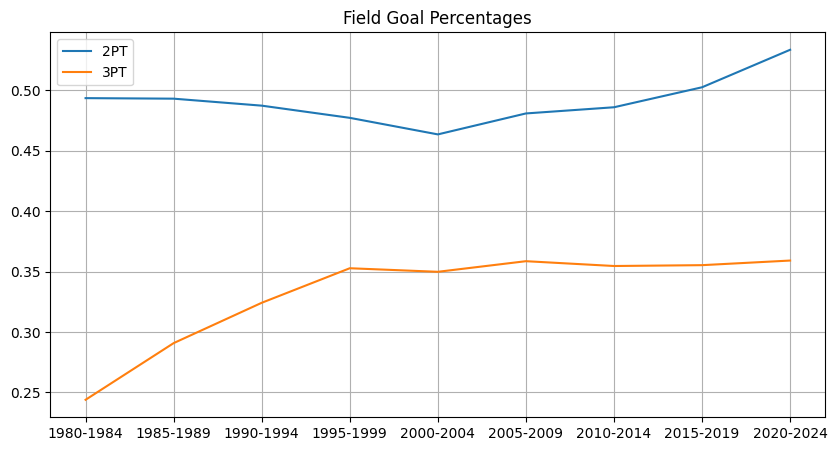

In [25]:
plt.figure(figsize=(10,5))
plt.plot(tm_sts_pg_grouped.index,tm_sts_pg_grouped["x2p_percent"], label="2PT")
plt.plot(tm_sts_pg_grouped.index,tm_sts_pg_grouped["x3p_percent"], label="3PT")
plt.title("Field Goal Percentages")
plt.legend()
plt.grid()
plt.show()

It is worth noting that the success rate of 3-point shots is almost always lower than that of 2-point shots, as shooting from beyond the arc involves a longer distance. However, the percentage saw some improvement in the first couple of decades after the introduction of the 3-point line to the league in 1979.

### When is a 3 point attempt more valuable than a 2 point attempt?

Consider the scenario in which an individual has a 50% success rate with 2-point shots and a 33.3% success rate with 3-point shots. In this case, the expected score for each type of shot would be almost equal, at 1.0 point per shot.

However, if an individual has a 40% success rate with 2-point shots and a 30% success rate with 3-point shots, the expected score for a 2-point shot would be 0.8 points, while the expected score for a 3-point shot would be 0.9 points. As such, the expected value of a 3-point shot is higher than that of a 2-point shot.

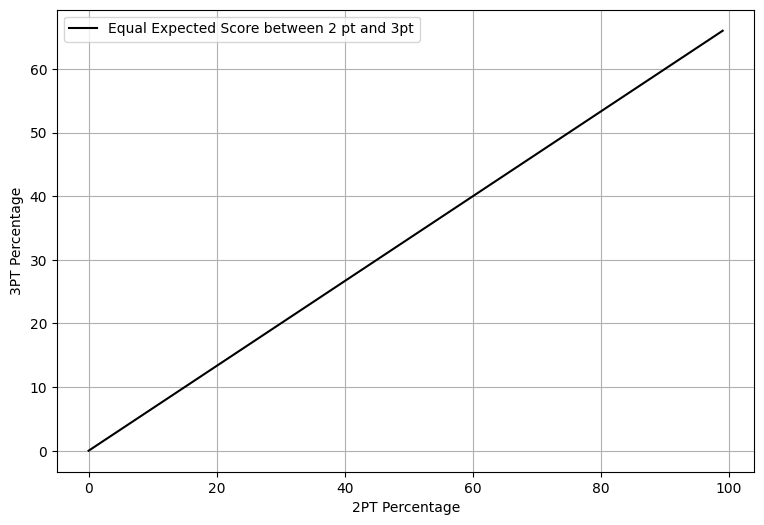

In [26]:
plt.figure(figsize=(9,6))

two_pt_percentage = [i for i in range(100)]
three = [i*2/3 for i in range(100)]

plt.plot(two_pt_percentage,three, label="Equal Expected Score between 2 pt and 3pt", c="black")
plt.legend()

plt.ylabel("3PT Percentage")
plt.xlabel("2PT Percentage")

plt.grid()
plt.show()

There are certain percentage values for 2-point and 3-point shots that result in the same expected score. The point where these percentages intersect is represented by the black line in the chart above.

In [27]:
cleaned_3pt = scoring_per_game[
    (scoring_per_game["x3pa_per_game"] >= 1) 
    & (scoring_per_game["x2pa_per_game"] >= 1)
    & (scoring_per_game["expected_pts_from_3pa"] >= scoring_per_game["expected_pts_from_2pa"])
]

In [28]:
cleaned_2pt = scoring_per_game[
    (scoring_per_game["x3pa_per_game"] >= 1) 
    & (scoring_per_game["x2pa_per_game"] >= 1)
    & (scoring_per_game["expected_pts_from_3pa"] < scoring_per_game["expected_pts_from_2pa"])
]

### Those Who Benefit from 2 Point Attempt and Those Who Benefit 3 Point Attempt

After analyzing the shot percentage of 2-point and 3-point shots for each player who attempted at least one of each type of shot throughout the season, I have placed markers on the chart to represent the findings.

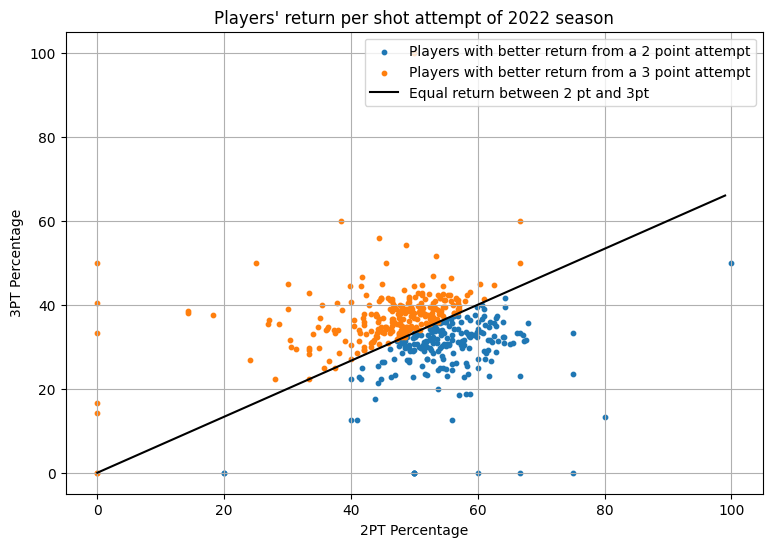

In [29]:
plt.figure(figsize=(9,6))

plt.scatter(
    cleaned_2pt[cleaned_2pt["season"] == 2022]["x2p_percent"]*100,
    cleaned_2pt[cleaned_2pt["season"] == 2022]["x3p_percent"]*100,
    label="Players with better return from a 2 point attempt",
    s=10
)
plt.scatter(
    cleaned_3pt[cleaned_3pt["season"] == 2022]["x2p_percent"]*100,
    cleaned_3pt[cleaned_3pt["season"] == 2022]["x3p_percent"]*100,
    label="Players with better return from a 3 point attempt",
    s=10
)

two_pt_percentage = [i for i in range(100)]
three = [i*2/3 for i in range(100)]

plt.plot(two_pt_percentage, three, label="Equal return between 2 pt and 3pt", c="black")

plt.ylabel("3PT Percentage")
plt.xlabel("2PT Percentage")

plt.title("Players' return per shot attempt of 2022 season")
plt.grid()
plt.legend()
plt.show()

The marker on the chart is color-coded based on whether the expected score from a player's 3-point shots is higher (orange) or lower (blue) than their expected score from 2-point shots.

If the expected score from a player's 3-point shots is higher, the marker will appear in orange and be placed on the upper left side of the line. Conversely, if the expected score from a player's 2-point shots is higher, the marker will appear in blue and be placed on the bottom right side of the line.

### Field Goal Percentage vs Expected Scores

We have established that in certain cases taking a 3-point shot, which is inherently more difficult to make, can be more efficient than taking a 2-point shot.

While I have already shown the average percentage changes of 2-point shots and 3-point shots over time, what does it look like when they are converted to expected scores?

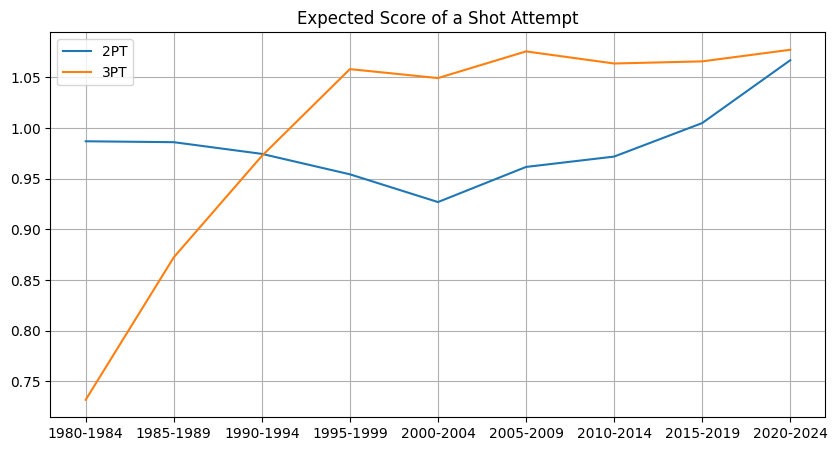

In [30]:
plt.figure(figsize=(10,5))
plt.plot(tm_sts_pg_grouped.index,tm_sts_pg_grouped["expected_pts_from_2pa"], label="2PT")
plt.plot(tm_sts_pg_grouped.index,tm_sts_pg_grouped["expected_pts_from_3pa"], label="3PT")
plt.title("Expected Score of a Shot Attempt")
plt.legend()
plt.grid()
plt.show()

When we convert the percentages into the actual value that each shot holds, it becomes clear that 3-point attempts have been more valuable than 2-point attempts for a significant period of time.

### Answer to "Why are players taking more 3 point shots now?"

To answer the question of why players are taking more 3-pointers now, it's because, on average, a 3-point attempt has the potential to generate more points than a 2-point attempt. 

However, as shown in the chart above, 3-point attempts have always been more valuable than 2-point attempts on average. 

This raises the next question:

---

<a id="q5"></a>

## Question 5: Why didn't they shoot more 3 pointers before?

Players are now attempting and making more 3-point shots than ever before because it is a more efficient way to score.

However, this is not a recent trend. As we saw earlier, 3-point attempts have had a higher expected value than 2-point attempts since the mid-1990s, with the largest gap between the two during 2000-2004.

### 3P% was high long before they started shooting 3s

This is the trend in the number of 3-point shot attempts per game, per team, since 1980.

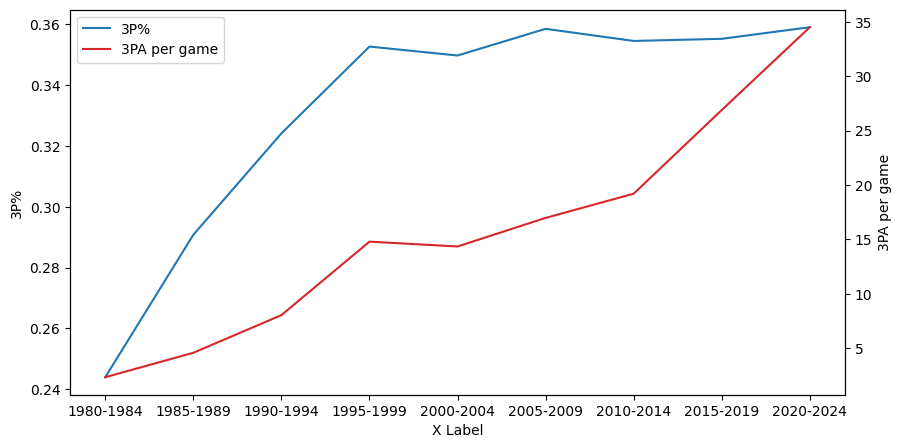

In [31]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.set_xlabel('X Label')
ax1.set_ylabel('3P%')
ax2.set_ylabel('3PA per game')

ln1 = ax1.plot(tm_sts_pg_grouped.index, tm_sts_pg_grouped['x3p_percent'], label='3P%', color='tab:blue')
ln2 = ax2.plot(tm_sts_pg_grouped.index, tm_sts_pg_grouped['x3pa_per_game'], label='3PA per game', color='tab:red')

# merge legends into one
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

Despite the fact that 3-point shots have been more efficient than 2-point shots for the majority of players, they have not taken many 3-point shots.

So, why did we see a surge in 3-pointers only a decade ago, and why are smaller players thriving just now?

### Were there less number of shooters? Not Really

Even if the average percentage is comparable to what we see today, it is possible that there were far fewer players attempting 3-point shots, which would have kept the percentage high.

However, this would have made it impossible for 3-point shots to be considered a legitimate offensive option across the entire league.

Let's take a look at the number of players whose 3-point shots would have been more beneficial than their 2-point shots.

In [32]:
rstr_pg_copy = rstr_pg
rstr_pg_copy["x3p_percent"] = rstr_pg_copy["x3p_percent"].fillna(value=0)
rstr_pg_copy["x2p_percent"] = rstr_pg_copy["x2p_percent"].fillna(value=0)
rstr_pg_copy["expected_pts_from_3pa"] = rstr_pg_copy["x3p_percent"] * 3
rstr_pg_copy["expected_pts_from_2pa"] = rstr_pg_copy["x2p_percent"] * 3

In [33]:
active_players_with_threes = rstr_pg_copy[
    (rstr_pg_copy["expected_pts_from_3pa"] >= rstr_pg_copy["expected_pts_from_2pa"]) 
    & (rstr_pg_copy["mp_per_game"] >= 12)
]

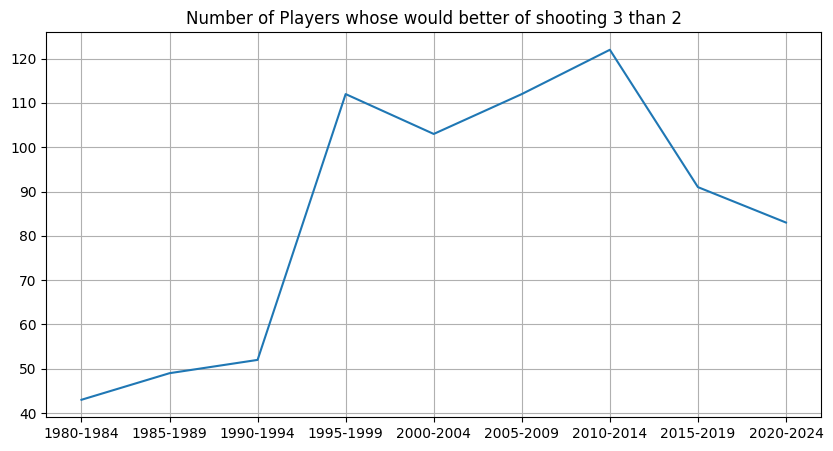

In [34]:
plt.figure(figsize=(10,5))
plt.plot(
    active_players_with_threes.groupby("5-yr").count().index,
    active_players_with_threes.groupby("5-yr").count()["player"]
)
plt.title("Number of Players whose would better of shooting 3 than 2")
plt.grid()
plt.show()

An interesting fact is that there were as many players between 1995-1999 who could expect to score more points from a 3-point shot than a 2-point shot as there are today.

Therefore, if these players had chosen to shoot more 3-pointers during their time, the recent surge in 3-pointers may have occurred much earlier.

### Answer to "Why didn't they shoot more 3 pointers before?" 

Based on this analysis, it is evident that players (or the coaches) were choosing not to shoot 3-pointers during that time.

It wasn't that players were bad at shooting 3-pointers and couldn't benefit from them, nor were there only a few players who were worth attempting 3-point shots.

There were players who could shoot 3-pointers well, and in many cases, they could have benefited more from shooting 3-pointers than 2-pointers.

---

<a id="takeaways"></a>

## Takeaways

Even though 3-point shot attempts on league average had a higher expected value than 2-point shot attempts, players were not shooting as many 3-pointers and the majority of points were scored within the 3-point line.

During the "2-pointer dominant" era, being shorter than the players around you was a disadvantage, which is why the top scorers at that time tended to be bigger in size.


However, from 2015-2019, players began shooting 3-pointers at a much higher volume and started to fully reap the benefits of these shots.

The increase in points earned from outside of the 3-point line resulted in more actions farther away from the basket, involving more running around and navigating through defenders. This shift in playstyle helped smaller players thrive, and being big became less important for success.